In [22]:
%matplotlib notebook
import importlib
from matplotlib import pyplot as plt
from input_encoding.population_coding.utils import gaussian, gen_population_coding
import lvq.lvq3
import lvq.lvq4
from lvq.lvq3 import LVQ3
from lvq.lvq4 import LVQ4
from sklearn import datasets
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
from som import SOM

In [23]:
with open('C:/Users/ehajizad/lava-nc/neuromorphic-continual-learning/tutorials/coil20_labels.npy', 'rb') as f:
    labels = np.load(f, allow_pickle=True)

In [24]:
with open('C:/Users/ehajizad/lava-nc/neuromorphic-continual-learning/tutorials/strided_coil20.npy', 'rb') as f:
    stride_filtered = np.load(f, allow_pickle=True)

In [25]:
scaled_input = 100 * stride_filtered
scaled_input = scaled_input.reshape((scaled_input.shape[0], stride_filtered.shape[1],-1))
print(scaled_input.shape)
flat_input=scaled_input.reshape((scaled_input.shape[0], -1))
print(flat_input.shape)

(1440, 8, 441)
(1440, 3528)


In [26]:
# Bound the feature to the [0,200] range simulating the rate code range
vmax=350
vmin=30
noise_max=100
bounded = scaled_input.copy()
bounded[bounded<vmin]=0  # below 10, no spike
bounded[bounded>vmax]=vmax # above 200, rate code saturates

# Calculate the noise value for each patch
sum_per_patch = bounded.sum(1)
noise = noise_max - sum_per_patch
noise[noise<0]=0 # also bounded in the range of [0,200]

# Append this noise feature to our feature vectors
bounded=np.append(bounded, noise[:,np.newaxis, :], axis=1)
print(bounded.shape) # new noise feature is now added

flat_bounded=bounded.reshape((bounded.shape[0], bounded.shape[1]*bounded.shape[2]))
print(flat_bounded.shape)

(1440, 9, 441)
(1440, 3969)


In [ ]:
X_emb = TSNE(n_components=2, perplexity=16, n_iter=4000).fit_transform(flat_input)
plt.figure()
sns.scatterplot(X_emb[:,0], X_emb[:,1], hue=labels, palette=sns.color_palette("hls", 20))

In [ ]:
X_emb = TSNE(n_components=3, perplexity=16, n_iter=4000).fit_transform(flat_bounded)
plt.figure()


<IPython.core.display.Javascript object>


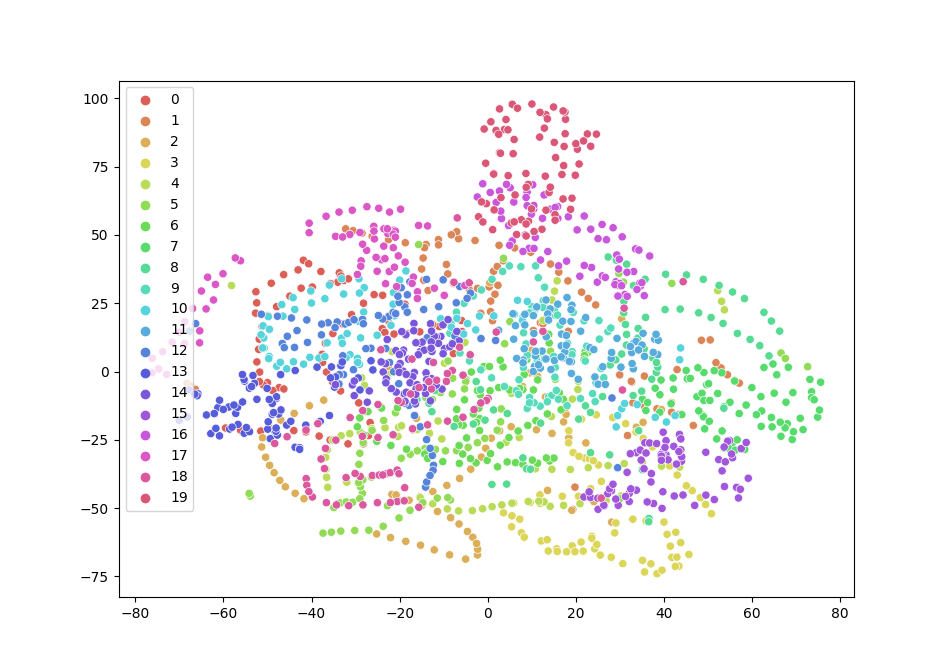

c:\users\ehajizad\lava-nc\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

In [21]:
plt.figure()
sns.scatterplot(X_emb[:,1], X_emb[:,2], hue=labels, palette=sns.color_palette("hls", 20))

In [128]:
importlib.reload(lvq.lvq3)
from lvq.lvq3 import LVQ3

X = flat_bounded
y = labels

n_epochs = 40
alpha = 0.02
alpha_decay = 'linear'
n_class = 20
n_protos = 300
n_sample_per_class = int(X.shape[0]/n_class)
training_ratio = 0.5

# # Random train-test split
# test_size = 0.3
# random_state = np.random.randint(1000)

# X = flat_bounded
# y = labels
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

# Take every nth sample as training for each class
n_tr_sample_per_class = int(n_sample_per_class*training_ratio)
mask = list(range(0,X.shape[0],int(n_sample_per_class/n_tr_sample_per_class)))
X_train = X[mask]
X_test = np.delete(X, mask, axis=0)
y_train = y[mask]
y_test = np.delete(y, mask, axis=0)

mlvq3 = LVQ3(bmu_metric='dot_product', random_protos=True, alpha_decay=alpha_decay,
             n_protos=n_protos, 
             n_class=n_class)
mlvq3.init_prototypes_from_data(X)
mlvq3.train_prototypes(x_train=X_train, y_train=y_train, x_test=X_test , y_test=y_test,
                       alpha_start=alpha, n_epochs=n_epochs, test_each_epoch=True, shuffle=False)
mlvq3.predict(X_test, y_test)



14.602410419208605 26.43759615534774
Initial prototypes:
 [[ 19.3   3.    0.3 ...  93.7 112.2 114.3]
 [  4.5  10.    8.4 ... 105.  133.   81. ]
 [ 12.6  15.1  26.8 ...  80.8 141.8  99.1]
 ...
 [  0.4   1.9   4.3 ...  93.9 110.7 128.8]
 [  7.9   2.8  24.6 ...  70.1  87.   92.8]
 [  6.4   4.9   0.3 ...  70.2  94.7 103. ]]
>epoch=0, lrate=0.020,  tr_err=0.253, test_err=0.411
>epoch=1, lrate=0.019,  tr_err=0.139, test_err=0.257
>epoch=2, lrate=0.019,  tr_err=0.071, test_err=0.203
>epoch=3, lrate=0.018,  tr_err=0.036, test_err=0.156
>epoch=4, lrate=0.018,  tr_err=0.024, test_err=0.124
>epoch=5, lrate=0.017,  tr_err=0.017, test_err=0.113
>epoch=6, lrate=0.017,  tr_err=0.018, test_err=0.115
>epoch=7, lrate=0.016,  tr_err=0.011, test_err=0.113
>epoch=8, lrate=0.016,  tr_err=0.014, test_err=0.114
>epoch=9, lrate=0.015,  tr_err=0.013, test_err=0.096
>epoch=10, lrate=0.015,  tr_err=0.011, test_err=0.099
>epoch=11, lrate=0.014,  tr_err=0.010, test_err=0.082
>epoch=12, lrate=0.014,  tr_err=0.007, t

0.9375

<IPython.core.display.Javascript object>


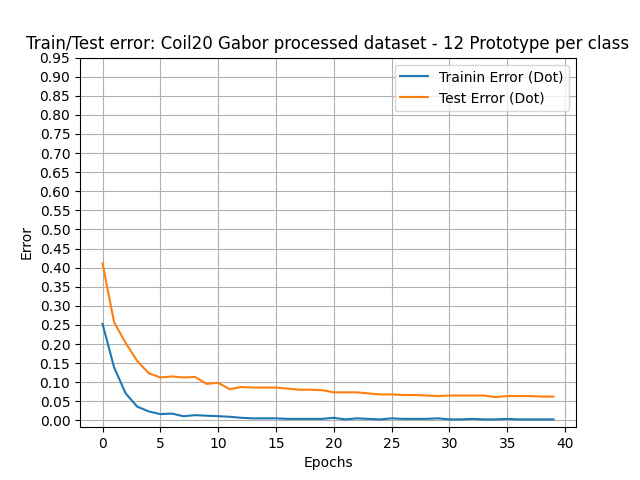

Text(0.5, 1.0, 'Train/Test error: Coil20 Gabor processed dataset - 12 Prototype per class')

In [129]:
plt.figure()
plt.plot(mlvq3.train_errors)
plt.plot(mlvq3.test_errors)
plt.yticks(np.arange(0,1,0.05))
plt.grid()

plt.legend(["Trainin Error (Dot)", 
            "Test Error (Dot)"])
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.title("Train/Test error: Coil20 Gabor processed dataset - 12 Prototype per class")

<IPython.core.display.Javascript object>


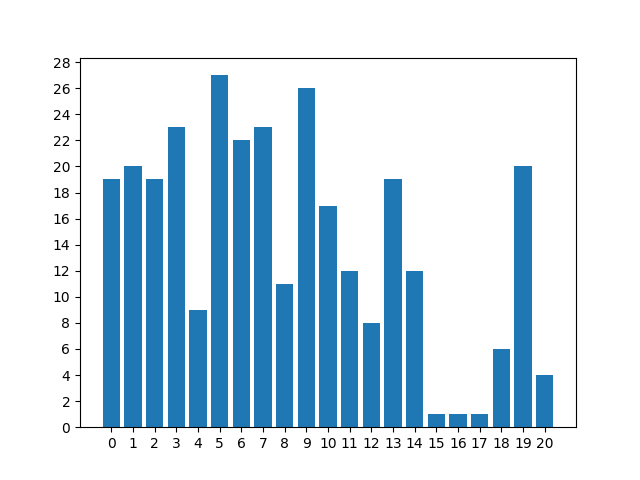

In [8]:
proto_labels = mlvq3.proto_labels.copy()
unique, counts = np.unique(proto_labels, return_counts=True)
plt.figure()
plt.bar(unique+1, counts)
plt.yticks(np.arange(0,30,2))
plt.xticks(np.arange(21))
plt.show()

In [18]:
importlib.reload(lvq.lvq1)
importlib.reload(lvq.lvq2)
importlib.reload(lvq.lvq3)
from lvq.lvq1 import LVQ1
from lvq.lvq2 import LVQ2
from lvq.lvq3 import LVQ3

X = flat_bounded
y = labels
# Take every nth sample as training for each class

#---------------------------------------------------------------------------------------------------
n_epochs = 40
alpha = 0.02
alpha_decay = 'linear'
n_class = 20
n_sample_per_class = int(X.shape[0]/n_class)
n_protos = 120

#---------------------------------------------------------------------------------------------------


lvqs = []
# n_train_samples = [1,2,3,4,6,8,9,12,18,24,36]
training_ratios = np.arange(0.02,0.54,0.04)
for ind, n in enumerate(training_ratios):
    
    n_tr_sample_per_class = int(n_sample_per_class*training_ratios[ind])
    mask = list(range(0,X.shape[0],int(n_sample_per_class/n_tr_sample_per_class)))
    X_train = X[mask]
    X_test = np.delete(X, mask, axis=0)
    y_train = y[mask]
    y_test = np.delete(y, mask, axis=0)
    
    print("training_ratio: ", training_ratios[ind])
    print("n_tr_sample_per_class: ", n_tr_sample_per_class)
    lvqs.append(LVQ3(bmu_metric='dot_product', random_protos=True, alpha_decay=alpha_decay,
                 n_protos=n_protos, n_class=n_class))
    
    lvqs[ind].train_prototypes(x_train=X_train, y_train=y_train, x_test=X_test , y_test=y_test,
                               alpha_start=alpha, n_epochs=n_epochs, test_each_epoch=True, shuffle=False)

training_ratio:  0.02
n_tr_sample_per_class:  1
Initial prototypes:
 [[  1.2   0.   17.6 ...  48.4  83.2  92.6]
 [  2.6   0.   29.6 ...  56.9 124.8 107.9]
 [  8.8   0.    3.7 ... 129.7  62.4  86.5]
 ...
 [ 10.1   0.   24.1 ...  83.4  80.  114.3]
 [  4.3   0.   15.5 ...  78.2 105.2 110.1]
 [  3.7   0.    4.7 ... 109.7 129.6  97.6]]
>epoch=0, lrate=0.020, error=45399.229, tr_err=0.200, test_err=0.880
>epoch=1, lrate=0.019, error=44740.516, tr_err=0.200, test_err=0.871
>epoch=2, lrate=0.019, error=43992.064, tr_err=0.150, test_err=0.851
>epoch=3, lrate=0.018, error=43308.235, tr_err=0.050, test_err=0.794
>epoch=4, lrate=0.018, error=42577.754, tr_err=0.050, test_err=0.735
>epoch=5, lrate=0.017, error=41846.458, tr_err=0.000, test_err=0.707
>epoch=6, lrate=0.017, error=41116.827, tr_err=0.000, test_err=0.689
>epoch=7, lrate=0.016, error=40421.004, tr_err=0.000, test_err=0.677
>epoch=8, lrate=0.016, error=39757.685, tr_err=0.000, test_err=0.665
>epoch=9, lrate=0.015, error=39125.640, tr_err

>epoch=14, lrate=0.013, error=233188.366, tr_err=0.007, test_err=0.282
>epoch=15, lrate=0.012, error=229792.024, tr_err=0.007, test_err=0.275
>epoch=16, lrate=0.012, error=226711.190, tr_err=0.007, test_err=0.281
>epoch=17, lrate=0.011, error=223851.210, tr_err=0.007, test_err=0.280
>epoch=18, lrate=0.011, error=221250.550, tr_err=0.007, test_err=0.281
>epoch=19, lrate=0.010, error=218808.920, tr_err=0.007, test_err=0.275
>epoch=20, lrate=0.010, error=216623.090, tr_err=0.007, test_err=0.279
>epoch=21, lrate=0.009, error=214556.903, tr_err=0.007, test_err=0.279
>epoch=22, lrate=0.009, error=212645.786, tr_err=0.007, test_err=0.280
>epoch=23, lrate=0.008, error=210900.155, tr_err=0.007, test_err=0.275
>epoch=24, lrate=0.008, error=209339.172, tr_err=0.007, test_err=0.275
>epoch=25, lrate=0.007, error=208155.465, tr_err=0.007, test_err=0.272
>epoch=26, lrate=0.007, error=206494.093, tr_err=0.007, test_err=0.274
>epoch=27, lrate=0.006, error=205298.885, tr_err=0.007, test_err=0.275
>epoch

>epoch=31, lrate=0.004, error=333171.460, tr_err=0.008, test_err=0.179
>epoch=32, lrate=0.004, error=332263.435, tr_err=0.008, test_err=0.177
>epoch=33, lrate=0.003, error=331743.842, tr_err=0.008, test_err=0.175
>epoch=34, lrate=0.003, error=330863.482, tr_err=0.008, test_err=0.176
>epoch=35, lrate=0.002, error=330285.185, tr_err=0.008, test_err=0.178
>epoch=36, lrate=0.002, error=330122.179, tr_err=0.008, test_err=0.177
>epoch=37, lrate=0.001, error=329496.651, tr_err=0.008, test_err=0.177
>epoch=38, lrate=0.001, error=329260.351, tr_err=0.008, test_err=0.177
>epoch=39, lrate=0.000, error=329125.373, tr_err=0.008, test_err=0.177
Final prototypes:
 [[  3.01   1.41  13.25 ... 112.16  94.44  83.84]
 [  2.52   1.5   20.17 ...  57.12  97.62 103.96]
 [  3.45   0.49   1.23 ... 105.55  91.63  92.18]
 ...
 [  1.7    9.2    5.4  ... 109.2   81.8  112.6 ]
 [ 19.92   5.62  22.52 ... 122.52  72.55  93.74]
 [ 15.58   2.74  16.85 ...  81.92  96.56  88.34]]
training_ratio:  0.21999999999999995
n_tr_

>epoch=0, lrate=0.020, error=1094511.025, tr_err=0.506, test_err=0.591
>epoch=1, lrate=0.019, error=1025902.792, tr_err=0.373, test_err=0.436
>epoch=2, lrate=0.019, error=952919.382, tr_err=0.225, test_err=0.357
>epoch=3, lrate=0.018, error=892121.560, tr_err=0.165, test_err=0.283
>epoch=4, lrate=0.018, error=844971.612, tr_err=0.129, test_err=0.267
>epoch=5, lrate=0.017, error=811973.763, tr_err=0.100, test_err=0.210
>epoch=6, lrate=0.017, error=787580.113, tr_err=0.083, test_err=0.203
>epoch=7, lrate=0.016, error=770096.549, tr_err=0.073, test_err=0.178
>epoch=8, lrate=0.016, error=756350.694, tr_err=0.065, test_err=0.160
>epoch=9, lrate=0.015, error=743941.549, tr_err=0.060, test_err=0.164
>epoch=10, lrate=0.015, error=733859.058, tr_err=0.054, test_err=0.149
>epoch=11, lrate=0.014, error=725856.451, tr_err=0.050, test_err=0.152
>epoch=12, lrate=0.014, error=717246.253, tr_err=0.044, test_err=0.142
>epoch=13, lrate=0.013, error=710750.821, tr_err=0.042, test_err=0.139
>epoch=14, lra

>epoch=18, lrate=0.011, error=1068930.686, tr_err=0.113, test_err=0.132
>epoch=19, lrate=0.010, error=1065086.792, tr_err=0.108, test_err=0.129
>epoch=20, lrate=0.010, error=1062484.632, tr_err=0.110, test_err=0.129
>epoch=21, lrate=0.009, error=1061370.653, tr_err=0.110, test_err=0.128
>epoch=22, lrate=0.009, error=1059273.974, tr_err=0.111, test_err=0.126
>epoch=23, lrate=0.008, error=1057559.172, tr_err=0.108, test_err=0.124
>epoch=24, lrate=0.008, error=1055707.668, tr_err=0.110, test_err=0.131
>epoch=25, lrate=0.007, error=1053980.085, tr_err=0.110, test_err=0.129
>epoch=26, lrate=0.007, error=1053199.389, tr_err=0.110, test_err=0.129
>epoch=27, lrate=0.006, error=1051894.921, tr_err=0.108, test_err=0.131
>epoch=28, lrate=0.006, error=1051625.542, tr_err=0.110, test_err=0.126
>epoch=29, lrate=0.005, error=1049796.359, tr_err=0.108, test_err=0.126
>epoch=30, lrate=0.005, error=1049494.888, tr_err=0.108, test_err=0.126
>epoch=31, lrate=0.004, error=1048029.297, tr_err=0.108, test_er

>epoch=35, lrate=0.002, error=997923.808, tr_err=0.061, test_err=0.082
>epoch=36, lrate=0.002, error=997863.353, tr_err=0.061, test_err=0.082
>epoch=37, lrate=0.001, error=997356.493, tr_err=0.060, test_err=0.082
>epoch=38, lrate=0.001, error=996094.110, tr_err=0.060, test_err=0.082
>epoch=39, lrate=0.000, error=997094.943, tr_err=0.060, test_err=0.082
Final prototypes:
 [[  0.02  12.74   3.5  ...  45.51  94.14  90.09]
 [  0.     0.     0.   ...   6.83  77.33  88.62]
 [  0.4    3.84   0.18 ...  56.9   96.27  73.04]
 ...
 [  5.88   2.74  12.   ...  97.12  85.51  55.76]
 [  1.32   0.07   4.19 ...  74.3   78.    71.62]
 [  4.01   8.89  51.64 ...  30.93  72.43 112.48]]
training_ratio:  0.49999999999999994
n_tr_sample_per_class:  35
Initial prototypes:
 [[  0.7   8.8   7.4 ...  74.8 125.7 103.5]
 [ 25.9   6.8   7.8 ...  82.4  84.7 104.8]
 [  1.    5.4   0.7 ... 103.4 119.1  84.9]
 ...
 [ 28.    6.1  23.  ...  69.3  73.8 112. ]
 [  6.1   3.3   7.2 ...  94.6  83.3  64.6]
 [  1.2   3.3   3.6 .

<IPython.core.display.Javascript object>


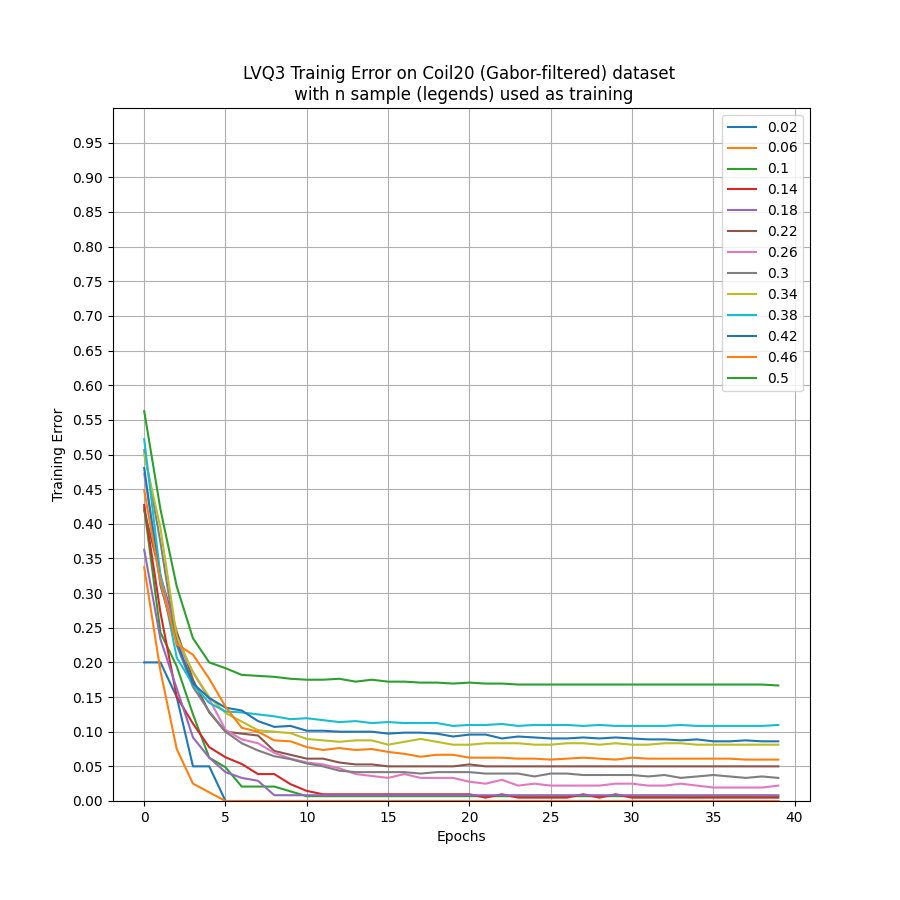

In [21]:
plt.figure(figsize=(9,9))
for n in range(len(lvqs)):
    plt.plot(lvqs[n].train_errors)
    
plt.ylim([0,1])
plt.yticks(np.arange(0,1,0.05))
plt.grid()
plt.legend(labels=np.around(training_ratios,2))
plt.xlabel("Epochs")
plt.ylabel("Training Error")
plt.title("LVQ3 Trainig Error on Coil20 (Gabor-filtered) dataset \n with n sample (legends) used as training")

plt.show()

In [ ]:
importlib.reload(lvq.lvq3)
from lvq.lvq3 import LVQ3

X = flat_bounded
y = labels

n_epochs = 40
alpha = 0.02
alpha_decay = 'linear'
n_class = 20
max_n_proto = 300
n_sample_per_class = int(X.shape[0]/n_class)
training_ratio = 0.40

# Take every nth sample as training for each class
n_tr_sample_per_class = int(n_sample_per_class*training_ratio)
mask = list(range(0,X.shape[0],int(n_sample_per_class/n_tr_sample_per_class)))
X_train = X[mask]
X_test = np.delete(X, mask, axis=0)
y_train = y[mask]
y_test = np.delete(y, mask, axis=0)

lvqs = []
for ind, n_protos in enumerate(range(10,max_n_proto+1,10)):
    print("n_protos: ", n_protos)
    lvqs.append(LVQ3(bmu_metric='dot_product', random_protos=True, alpha_decay=alpha_decay,
                 n_protos=n_protos, n_class=n_class))
    
    lvqs[ind].train_prototypes(x_train=X_train, y_train=y_train, x_test=X_test , y_test=y_test,
                               alpha_start=alpha, n_epochs=n_epochs, test_each_epoch=True, shuffle=False)

<IPython.core.display.Javascript object>


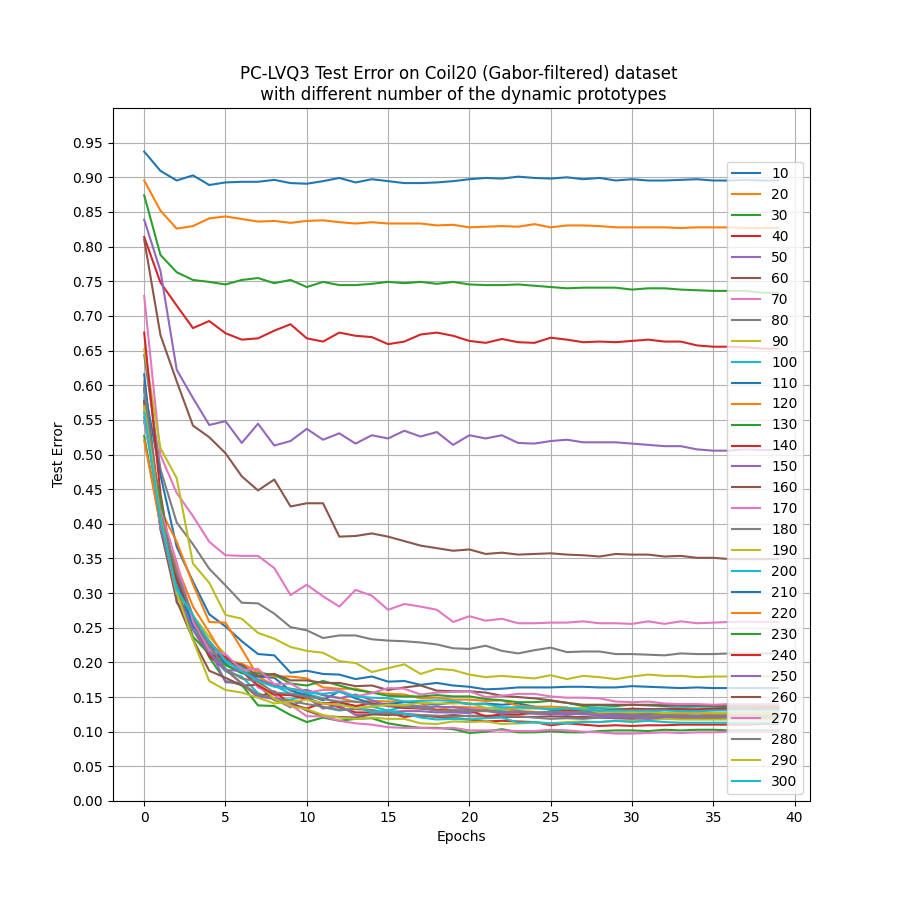

In [24]:
plt.figure(figsize=(9,9))
for ind, n_protos in enumerate(range(10,max_n_proto+1,10)):
    plt.plot(lvqs[ind].test_errors)

plt.ylim([0,1])
plt.yticks(np.arange(0,1,0.05))
plt.grid()
plt.legend(labels=np.arange(10,max_n_proto+1,10), loc='lower right')
plt.xlabel("Epochs")
plt.ylabel("Test Error")
plt.title("PC-LVQ3 Test Error on Coil20 (Gabor-filtered) dataset \n with different number of the dynamic prototypes")

plt.show()

<IPython.core.display.Javascript object>


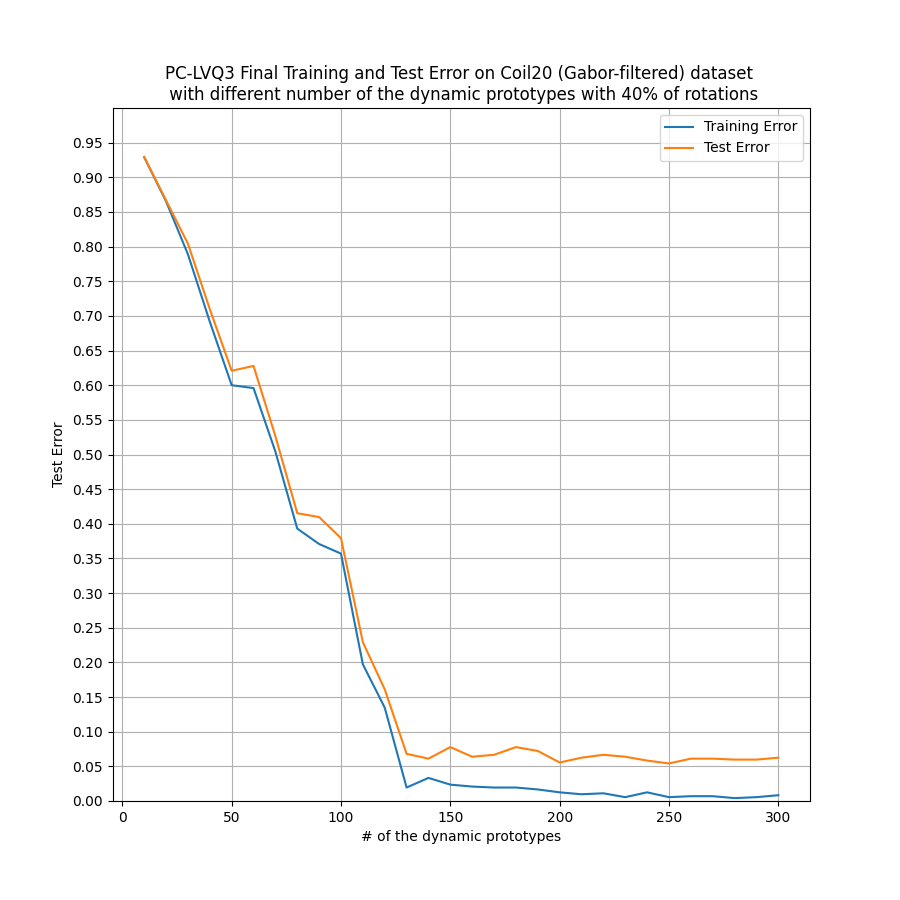

In [34]:
plt.figure(figsize=(9,9))
tr_err=[]
test_err=[]
for ind, n_protos in enumerate(range(10,max_n_proto+1,10)):
    test_err.append(lvqs[ind].test_errors[-1])
    tr_err.append(lvqs[ind].train_errors[-1])
    
plt.plot(np.arange(10,max_n_proto+1,10), tr_err)
plt.plot(np.arange(10,max_n_proto+1,10), test_err)


plt.ylim([0,1])
plt.yticks(np.arange(0,1,0.05))
plt.grid()
plt.xlabel("# of the dynamic prototypes")
plt.ylabel("Test Error")
plt.legend(labels=["Training Error","Test Error"])
plt.title("PC-LVQ3 Final Training and Test Error on Coil20 (Gabor-filtered) dataset \n with different number of the dynamic prototypes with 40% of rotations")

plt.show()

In [34]:
importlib.reload(lvq.lvq4)
from lvq.lvq4 import LVQ4

X = flat_bounded
y = labels

n_epochs = 10
n_protos = 500
alpha_start = 0.1
tau_alpha_dc = 2
tau_alpha_gr = 9
n_class = 20
n_sample_per_class = int(X.shape[0]/n_class)
training_ratio = 0.4

# Take every nth sample as training for each class
n_tr_sample_per_class = int(n_sample_per_class*training_ratio)
mask = list(range(0,X.shape[0],int(n_sample_per_class/n_tr_sample_per_class)))
X_train = X[mask]
X_test = np.delete(X, mask, axis=0)
y_train = y[mask]
y_test = np.delete(y, mask, axis=0)

mlvq = LVQ4(bmu_metric='dot_product', random_protos=True,
            n_protos=n_protos, 
            n_class=n_class, 
            alpha_start=alpha_start)

mlvq.init_prototypes_from_data(X)

mlvq.train_prototypes(x_train=X_train, y_train=y_train, x_test=X_test , y_test=y_test,
                              tau_alpha_dc=tau_alpha_dc, tau_alpha_gr=tau_alpha_gr, n_epochs=n_epochs, 
                              test_each_epoch=True, shuffle=False)
mlvq.predict(X_test, y_test)

>epoch=0, lrate=0.000, tr_err=0.768, test_err=0.214
>epoch=1, lrate=0.002, tr_err=0.212, test_err=0.161
>epoch=2, lrate=0.000, tr_err=0.039, test_err=0.149
>epoch=3, lrate=0.000, tr_err=0.026, test_err=0.142
>epoch=4, lrate=0.000, tr_err=0.021, test_err=0.129
>epoch=5, lrate=0.000, tr_err=0.019, test_err=0.126
>epoch=6, lrate=0.000, tr_err=0.017, test_err=0.124
>epoch=7, lrate=0.000, tr_err=0.014, test_err=0.122
>epoch=8, lrate=0.000, tr_err=0.014, test_err=0.122
>epoch=9, lrate=0.001, tr_err=0.014, test_err=0.122


0.8777777777777778

In [10]:
importlib.reload(lvq.lvq4)
from lvq.lvq4 import LVQ4

X = flat_bounded
y = labels

n_epochs = 4
alphas = np.arange(0.005,0.021,0.004) #np.geomspace(0.01, 1, num=10)
d_alphas = np.arange(0.1,1,0.1)
n_class = 20
n_protos = 200
n_sample_per_class = int(X.shape[0]/n_class)
training_ratio = 0.38

n_tr_sample_per_class = int(n_sample_per_class*training_ratio)
mask = list(range(0,X.shape[0],int(n_sample_per_class/n_tr_sample_per_class)))
X_train = X[mask]
X_test = np.delete(X, mask, axis=0)
y_train = y[mask]
y_test = np.delete(y, mask, axis=0)

accs = np.zeros((len(alphas),len(d_alphas)))
for a, alpha in enumerate(alphas):
    for d, d_alpha in enumerate(d_alphas):
        mlvq = LVQ4(bmu_metric='dot_product', random_protos=True,
             n_protos=n_protos, 
             n_class=n_class,
             alpha_start=alpha)
        mlvq.train_prototypes(x_train=X_train, y_train=y_train, x_test=X_test , y_test=y_test,
                              d_alpha=d_alpha, n_epochs=n_epochs, test_each_epoch=False, shuffle=False)
        accs[a,d] = mlvq.predict(X_test, y_test)
        print("acc: ",accs[a,d])

Initial prototypes:
 [[11.5 73.8 47.9 ...  5.5 13.2  4.7]
 [13.4  3.5  0.4 ... 12.7 21.6 25. ]
 [55.8  2.8 17.3 ... 49.3 29.7 10.7]
 ...
 [30.7 41.1  2.2 ... 30.9 12.9 55.4]
 [30.3  8.  22.6 ... 50.9 12.1 26.6]
 [42.4 17.6 36.  ... 56.3 20.9 16.1]]
>epoch=0, lrate=0.005, tr_err=0.504, test_err=0.000
>epoch=1, lrate=0.000, tr_err=0.626, test_err=0.000
>epoch=2, lrate=0.000, tr_err=0.572, test_err=0.000
>epoch=3, lrate=1.000, tr_err=0.190, test_err=0.928
acc:  0.07222222222222219
Initial prototypes:
 [[ 7.9  5.8 25.3 ... 12.7  2.9 34.8]
 [ 8.6 24.8  1.  ... 22.1 23.2 48.9]
 [33.8  5.4 14.8 ...  8.8  7.8 32.4]
 ...
 [10.4 16.6 20.2 ... 10.6 16.8  7.8]
 [34.3 34.9 16.7 ... 19.7  1.4 59.4]
 [39.5  9.9 24.3 ... 38.9 12.1 61.8]]
>epoch=0, lrate=0.005, tr_err=0.521, test_err=0.000
>epoch=1, lrate=0.000, tr_err=0.496, test_err=0.000
>epoch=2, lrate=1.000, tr_err=0.169, test_err=0.000
>epoch=3, lrate=0.000, tr_err=0.890, test_err=0.896
acc:  0.10416666666666663
Initial prototypes:
 [[27.3  2.4  

Initial prototypes:
 [[ 6.3 38.7 11.2 ... 19.4 45.8 66.6]
 [27.5 41.4 15.9 ... 20.6 80.4 17.8]
 [30.5 26.7 49.  ... 15.3 26.9 33.6]
 ...
 [28.3 10.  43.8 ...  0.1 29.5 39.8]
 [20.3  0.3 16.6 ...  8.3  9.2 27.9]
 [ 5.2 12.6 26.3 ... 23.8 11.8 19.7]]
>epoch=0, lrate=0.009, tr_err=0.404, test_err=0.000
>epoch=1, lrate=0.009, tr_err=0.351, test_err=0.000
>epoch=2, lrate=0.003, tr_err=0.308, test_err=0.000
>epoch=3, lrate=0.003, tr_err=0.242, test_err=0.465
acc:  0.5347222222222222
Initial prototypes:
 [[35.5  5.7 41.3 ... 24.7  4.6  0.2]
 [ 5.9  6.4 31.8 ...  1.  42.9 11.6]
 [56.5 24.4  1.6 ... 35.3 30.3 41. ]
 ...
 [14.3  4.4 18.7 ...  1.6 47.  20. ]
 [ 4.2 18.  13.5 ... 38.9 13.6 34.9]
 [65.5 14.9 14.6 ... 58.8  7.5 19.3]]
>epoch=0, lrate=0.000, tr_err=0.653, test_err=0.000
>epoch=1, lrate=0.013, tr_err=0.393, test_err=0.000
>epoch=2, lrate=0.013, tr_err=0.328, test_err=0.000
>epoch=3, lrate=0.013, tr_err=0.297, test_err=0.590
acc:  0.4097222222222222
Initial prototypes:
 [[23.4  2.3 24.

Initial prototypes:
 [[33.7 49.6 35.9 ... 32.8 24.1 22.8]
 [83.9 34.  23.5 ... 47.  58.7 32.7]
 [52.3 10.8 55.  ... 39.1  5.8  4.9]
 ...
 [ 7.1 32.  47.6 ... 15.7 33.8  3.3]
 [23.3  4.6 50.7 ...  8.1 24.5 25.6]
 [17.4 52.7 40.4 ... 25.4 19.2 26. ]]
>epoch=0, lrate=0.017, tr_err=0.349, test_err=0.000
>epoch=1, lrate=0.011, tr_err=0.310, test_err=0.000
>epoch=2, lrate=0.011, tr_err=0.286, test_err=0.000
>epoch=3, lrate=0.021, tr_err=0.249, test_err=0.564
acc:  0.4361111111111111
Initial prototypes:
 [[22.7 10.6 22.4 ...  4.3  0.2  6. ]
 [ 3.2 21.8 31.2 ... 19.7 64.7 20. ]
 [ 4.8 21.4 20.3 ... 30.5  6.4  2.1]
 ...
 [28.6  1.7 43.7 ... 20.2  3.4 15.3]
 [25.7 21.  28.5 ... 34.  41.6 31.4]
 [11.3 68.  43.8 ... 33.1 10.4 26.4]]
>epoch=0, lrate=0.017, tr_err=0.340, test_err=0.000
>epoch=1, lrate=0.017, tr_err=0.306, test_err=0.000
>epoch=2, lrate=0.017, tr_err=0.272, test_err=0.000
>epoch=3, lrate=0.012, tr_err=0.229, test_err=0.443
acc:  0.5569444444444445


<IPython.core.display.Javascript object>


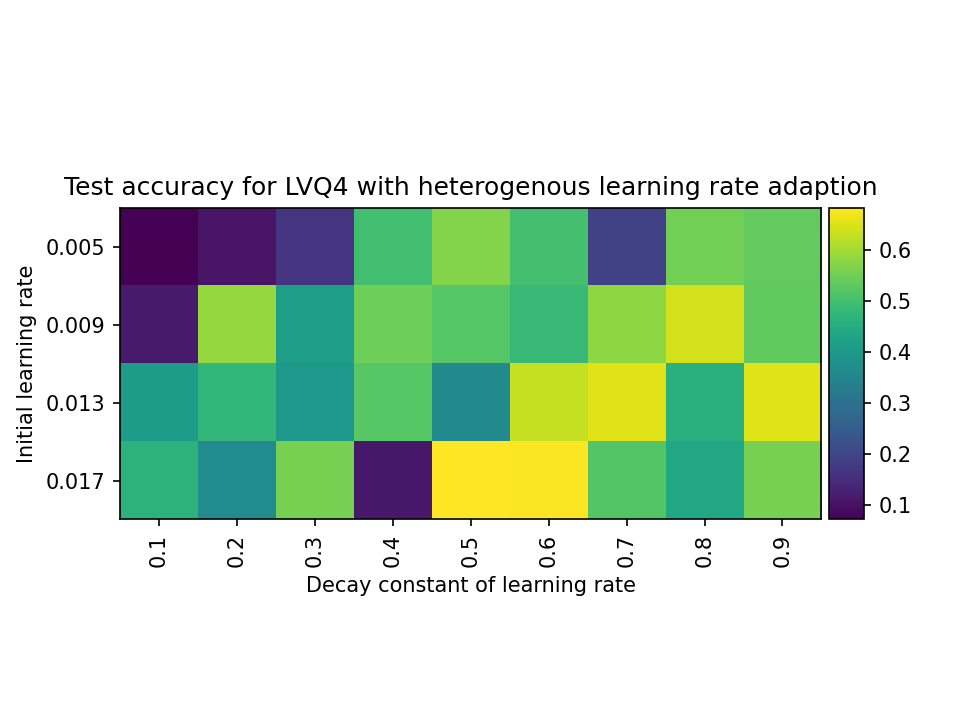

In [11]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig = plt.figure()
im=plt.imshow(accs)
ax = fig.axes[0]
plt.ylabel("Initial learning rate")
plt.xlabel("Decay constant of learning rate")

plt.xticks(ticks=np.arange(len(d_alphas)),labels=d_alphas.round(2), rotation=90)
plt.yticks(np.arange(len(alphas)),alphas.round(3))
# ax.set_yticks(np.arange(len(alphas)))
# ax.set_yticklabels(alphas, fontsize=10)
# plt.xticks(sigmas)
# plt.yticks(n_neurons)
plt.title("Test accuracy for LVQ4 with heterogenous learning rate adaption")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)
plt.show()

In [21]:
importlib.reload(lvq.lvq4)
from lvq.lvq4 import LVQ4

X = flat_bounded
y = labels

n_epochs = 4
alphas = 0.01 #np.geomspace(0.01, 1, num=10)
tau_alpha_dc_list = np.arange(1,27,2)
tau_alpha_gr_list = np.arange(1,27,2)
n_class = 20
n_protos = 300
n_sample_per_class = int(X.shape[0]/n_class)
training_ratio = 0.38

n_tr_sample_per_class = int(n_sample_per_class*training_ratio)
mask = list(range(0,X.shape[0],int(n_sample_per_class/n_tr_sample_per_class)))
X_train = X[mask]
X_test = np.delete(X, mask, axis=0)
y_train = y[mask]
y_test = np.delete(y, mask, axis=0)

accs = np.zeros((len(tau_alpha_gr_list),len(tau_alpha_dc_list)))
for dc, tau_alpha_dc in enumerate(tau_alpha_dc_list):
    for gr, tau_alpha_gr in enumerate(tau_alpha_gr_list):
        mlvq = LVQ4(bmu_metric='dot_product', random_protos=True,
             n_protos=n_protos, 
             n_class=n_class,
             alpha_start=alpha)
        mlvq.train_prototypes(x_train=X_train, y_train=y_train, x_test=X_test , y_test=y_test,
                              tau_alpha_dc=tau_alpha_dc, tau_alpha_gr=tau_alpha_gr,
                              n_epochs=n_epochs, test_each_epoch=False, shuffle=False)
        accs[gr,dc] = mlvq.predict(X_test, y_test)
        print("acc: ",accs[gr,dc])

Initial prototypes:
 [[ 1.9 40.7  1.4 ...  3.9 30.9 54.5]
 [26.3  5.   2.7 ... 16.2 44.1  0.7]
 [28.1 12.9  5.7 ... 12.2  2.  25.2]
 ...
 [27.8 17.8 45.2 ... 34.   8.8 37.8]
 [24.6 31.3 22.5 ... 17.9 18.9 16.7]
 [ 5.5 10.2 12.3 ... 50.1  8.3 27.3]]
>epoch=0, lrate=0.017, tr_err=0.322, test_err=0.000
>epoch=1, lrate=0.017, tr_err=0.294, test_err=0.000
>epoch=2, lrate=0.000, tr_err=0.696, test_err=0.000
>epoch=3, lrate=0.017, tr_err=0.269, test_err=0.606
acc:  0.3944444444444445
Initial prototypes:
 [[19.7 16.4 29.4 ... 15.  43.  28.8]
 [40.5 48.2 48.6 ...  1.3 23.7  2.9]
 [15.6 23.8 58.3 ... 25.1 14.4 12. ]
 ...
 [ 8.4  3.2  7.5 ...  3.7 31.2  7.7]
 [11.7 34.  53.6 ...  1.5 58.5 23.3]
 [13.7 17.2 20.8 ...  2.8 27.  36.6]]
>epoch=0, lrate=0.012, tr_err=0.411, test_err=0.000
>epoch=1, lrate=0.003, tr_err=0.344, test_err=0.000
>epoch=2, lrate=0.001, tr_err=0.299, test_err=0.000
>epoch=3, lrate=0.000, tr_err=0.301, test_err=0.454
acc:  0.5458333333333334
Initial prototypes:
 [[11.3 23.2  3.

>epoch=0, lrate=0.017, tr_err=0.328, test_err=0.000
>epoch=1, lrate=0.017, tr_err=0.299, test_err=0.000
>epoch=2, lrate=0.000, tr_err=0.688, test_err=0.000
>epoch=3, lrate=0.007, tr_err=0.239, test_err=0.432
acc:  0.5680555555555555
Initial prototypes:
 [[11.8  9.6 67.5 ...  3.3 12.9  8.2]
 [ 0.5 17.4 25.4 ... 35.3  5.9 10.1]
 [21.6 12.   1.1 ... 22.9  0.2 15.4]
 ...
 [ 0.8 51.4  6.6 ... 30.1 41.3 16.9]
 [ 8.9  9.4 28.9 ... 33.8 23.8 39.4]
 [ 3.8 29.7 54.6 ... 35.4 52.6  4.9]]
>epoch=0, lrate=0.017, tr_err=0.315, test_err=0.000
>epoch=1, lrate=0.017, tr_err=0.312, test_err=0.000
>epoch=2, lrate=0.017, tr_err=0.276, test_err=0.000
>epoch=3, lrate=0.017, tr_err=0.240, test_err=0.447
acc:  0.5527777777777778
Initial prototypes:
 [[41.  29.  11.5 ... 10.2 44.3  6.6]
 [ 3.  66.  29.9 ... 34.1 10.1  0.1]
 [38.8 21.4 10.1 ... 25.2 53.7 23.9]
 ...
 [23.7  4.  28.3 ...  2.4 18.3  6.8]
 [ 2.2 37.4  1.9 ... 65.3 34.7 41.3]
 [29.7  3.7 61.9 ...  9.6  3.6  5.2]]
>epoch=0, lrate=0.017, tr_err=0.333,

>epoch=0, lrate=0.012, tr_err=0.343, test_err=0.000
>epoch=1, lrate=0.012, tr_err=0.321, test_err=0.000
>epoch=2, lrate=0.010, tr_err=0.285, test_err=0.000
>epoch=3, lrate=0.009, tr_err=0.247, test_err=0.475
acc:  0.525
Initial prototypes:
 [[ 6.3 36.2 66.8 ... 17.5 13.1 43.6]
 [24.7 31.4  6.9 ... 10.5 18.7 22.6]
 [ 8.5 28.4 70.8 ... 23.  38.5  9. ]
 ...
 [61.1  3.9 13.6 ... 29.2  7.   9.1]
 [51.8 13.1  1.4 ... 12.5  2.7 13.5]
 [15.9 37.7 25.1 ...  3.7 39.4 39.6]]
>epoch=0, lrate=0.017, tr_err=0.344, test_err=0.000
>epoch=1, lrate=0.010, tr_err=0.308, test_err=0.000
>epoch=2, lrate=0.017, tr_err=0.267, test_err=0.000
>epoch=3, lrate=0.017, tr_err=0.235, test_err=0.476
acc:  0.5236111111111111
Initial prototypes:
 [[12.3 40.   1.  ...  5.6 37.6  8.8]
 [37.3  2.9 18.1 ...  3.6 51.  30.6]
 [41.7  2.9 29.7 ... 14.7  6.1 31.9]
 ...
 [16.8 35.8  5.5 ...  7.8 20.4  8.8]
 [42.4 20.5 21.  ... 47.  17.4 24.6]
 [20.  40.9 15.4 ... 11.4 10.3 29.9]]
>epoch=0, lrate=0.017, tr_err=0.329, test_err=0.0

>epoch=1, lrate=0.013, tr_err=0.307, test_err=0.000
>epoch=2, lrate=0.017, tr_err=0.260, test_err=0.000
>epoch=3, lrate=0.012, tr_err=0.228, test_err=0.396
acc:  0.6041666666666667
Initial prototypes:
 [[ 8.9 12.6 48.  ... 33.9 70.7 29.1]
 [29.5  0.3 40.7 ... 52.3  2.5 22.4]
 [40.7 12.9 24.  ... 59.7  3.2 15.8]
 ...
 [21.2 21.8 16.6 ...  7.6 22.8  1.9]
 [20.6 58.6  5.5 ... 12.6 14.4  5.3]
 [ 0.9  5.7  6.5 ... 16.6 53.2  8.7]]
>epoch=0, lrate=0.017, tr_err=0.346, test_err=0.000
>epoch=1, lrate=0.017, tr_err=0.318, test_err=0.000
>epoch=2, lrate=0.017, tr_err=0.269, test_err=0.000
>epoch=3, lrate=0.017, tr_err=0.231, test_err=0.479
acc:  0.5208333333333333
Initial prototypes:
 [[68.6 26.6 30.2 ... 77.  19.5 24.3]
 [47.7 16.5 15.7 ... 12.4 47.  63.4]
 [45.3 50.3  8.6 ...  2.5 26.1 24.4]
 ...
 [ 9.  17.8  0.5 ... 29.  15.3 30.1]
 [65.5 35.4 22.4 ...  1.9 20.5  5.4]
 [43.8 12.4  2.1 ... 11.5  8.8 40.1]]
>epoch=0, lrate=0.017, tr_err=0.331, test_err=0.000
>epoch=1, lrate=0.015, tr_err=0.332,

>epoch=1, lrate=0.014, tr_err=0.304, test_err=0.000
>epoch=2, lrate=0.001, tr_err=0.279, test_err=0.000
>epoch=3, lrate=0.017, tr_err=0.239, test_err=0.499
acc:  0.5013888888888889
Initial prototypes:
 [[17.2 16.  16.1 ... 40.4 48.9 32.1]
 [ 6.5 10.9 12.1 ... 14.2 37.1 18.4]
 [39.2  1.8  5.6 ... 25.5  4.8 55.1]
 ...
 [ 3.7 36.1 47.3 ... 11.4 17.1  7.5]
 [50.5 35.5 44.5 ... 37.2 30.5 32.9]
 [15.1 18.4 46.6 ... 67.   8.9 32. ]]
>epoch=0, lrate=0.017, tr_err=0.336, test_err=0.000
>epoch=1, lrate=0.017, tr_err=0.303, test_err=0.000
>epoch=2, lrate=0.017, tr_err=0.272, test_err=0.000
>epoch=3, lrate=0.017, tr_err=0.221, test_err=0.475
acc:  0.525
Initial prototypes:
 [[27.   3.2 10.9 ... 37.3 32.8 20.3]
 [15.7 33.1 12.2 ... 29.2 21.3 43.1]
 [54.1 62.7 17.  ... 55.9 15.1 32.4]
 ...
 [51.5 22.8 18.9 ...  9.8 46.3 34.6]
 [ 6.8 32.1 17.9 ... 52.9 46.7 10. ]
 [29.2 14.2 28.1 ... 30.4 15.7 33. ]]
>epoch=0, lrate=0.017, tr_err=0.319, test_err=0.000
>epoch=1, lrate=0.017, tr_err=0.315, test_err=0.0

>epoch=2, lrate=0.014, tr_err=0.274, test_err=0.000
>epoch=3, lrate=0.017, tr_err=0.264, test_err=0.510
acc:  0.4902777777777778
Initial prototypes:
 [[86.4 33.3  1.9 ... 54.3 13.  46.8]
 [ 1.   7.8 57.7 ... 62.4 36.2 33.6]
 [ 1.5  9.1 25.6 ...  7.6  6.6 38.4]
 ...
 [28.5 25.1 40.2 ...  0.8 35.2 19.7]
 [ 9.5 39.8 26.6 ... 32.6 33.9 20.4]
 [41.  49.6 22.2 ...  9.2 11.5 19.9]]
>epoch=0, lrate=0.017, tr_err=0.333, test_err=0.000
>epoch=1, lrate=0.015, tr_err=0.315, test_err=0.000
>epoch=2, lrate=0.012, tr_err=0.289, test_err=0.000
>epoch=3, lrate=0.017, tr_err=0.243, test_err=0.533
acc:  0.4666666666666667
Initial prototypes:
 [[50.8 27.3 37.5 ... 53.7  1.3 37.9]
 [45.7  9.9  0.1 ... 14.  14.9 32.3]
 [68.6 17.5 24.2 ... 25.7 45.3  8.6]
 ...
 [43.7 20.8  3.1 ... 50.7  5.9  7.6]
 [ 1.5 22.6  4.7 ... 50.5 12.1 28.9]
 [29.1 20.5 22.5 ... 35.1 24.2 52.1]]
>epoch=0, lrate=0.017, tr_err=0.331, test_err=0.000
>epoch=1, lrate=0.017, tr_err=0.293, test_err=0.000
>epoch=2, lrate=0.000, tr_err=0.319,

>epoch=2, lrate=0.017, tr_err=0.276, test_err=0.000
>epoch=3, lrate=0.006, tr_err=0.226, test_err=0.336
acc:  0.6638888888888889
Initial prototypes:
 [[ 32.4  36.4  50.  ...   2.2  39.   14.9]
 [ 13.1  39.4   4.6 ...  22.3  21.1  28. ]
 [ 43.7  32.6   0.6 ...  34.9 114.1   8.1]
 ...
 [ 43.8  20.9  14.7 ...   6.8  31.2  35.2]
 [ 14.1   0.7  16.3 ...  25.2  39.1  26.1]
 [  1.1  58.7   9.3 ...  43.3   3.   16.5]]
>epoch=0, lrate=0.017, tr_err=0.346, test_err=0.000
>epoch=1, lrate=0.017, tr_err=0.290, test_err=0.000
>epoch=2, lrate=0.015, tr_err=0.278, test_err=0.000
>epoch=3, lrate=0.017, tr_err=0.272, test_err=0.508
acc:  0.4916666666666667
Initial prototypes:
 [[23.7 10.9 52.5 ... 26.8 18.4 14.7]
 [ 6.1 59.9 52.6 ... 68.7 15.3  3.7]
 [ 2.2 76.5 11.3 ...  0.7 29.9  6.7]
 ...
 [15.8  4.7  5.6 ... 16.5  1.6 43.2]
 [13.2 30.1 25.9 ... 49.2  1.4 78.2]
 [20.6  1.9  7.9 ... 51.7 27.1 22.9]]
>epoch=0, lrate=0.017, tr_err=0.326, test_err=0.000
>epoch=1, lrate=0.017, tr_err=0.317, test_err=0.000


>epoch=3, lrate=0.017, tr_err=0.274, test_err=0.600
acc:  0.4
Initial prototypes:
 [[ 6.5 21.4 53.  ... 35.5 57.3 27.7]
 [22.7 29.3 34.6 ... 13.1  8.6 32.1]
 [27.   0.4 11.9 ... 11.3 28.1 18. ]
 ...
 [33.6 23.6 19.  ... 59.6  3.3  5.5]
 [25.4 78.8 22.7 ... 60.4 16.7  1.7]
 [10.3 52.4 35.9 ... 32.5  7.  21.1]]
>epoch=0, lrate=0.017, tr_err=0.328, test_err=0.000
>epoch=1, lrate=0.017, tr_err=0.307, test_err=0.000
>epoch=2, lrate=0.017, tr_err=0.293, test_err=0.000
>epoch=3, lrate=0.017, tr_err=0.275, test_err=0.556
acc:  0.4444444444444444
Initial prototypes:
 [[33.3  1.5 50.7 ... 17.6 22.9  3.7]
 [34.6  1.4 33.1 ... 24.5 23.7 23.9]
 [45.5 12.4 50.4 ... 46.8 22.   8.5]
 ...
 [ 8.3 50.  44.1 ... 46.3 24.2 18. ]
 [58.  15.2 55.  ...  6.4 47.5  4.6]
 [26.3 15.6  2.6 ... 27.1 10.  20.3]]
>epoch=0, lrate=0.017, tr_err=0.339, test_err=0.000
>epoch=1, lrate=0.017, tr_err=0.296, test_err=0.000
>epoch=2, lrate=0.015, tr_err=0.267, test_err=0.000
>epoch=3, lrate=0.017, tr_err=0.246, test_err=0.503

acc:  0.5708333333333333
Initial prototypes:
 [[19.  52.  19.1 ... 23.9 14.4 37.4]
 [ 3.2 55.9 77.2 ... 42.1 30.8 49.8]
 [27.9 45.9 27.6 ...  9.5 36.6 13.9]
 ...
 [82.4 43.  10.7 ... 28.5 19.1 31.9]
 [17.4 15.2 15.6 ... 22.1 13.4 18.9]
 [58.1 44.  25.6 ... 12.4 38.5 17.9]]
>epoch=0, lrate=0.016, tr_err=0.321, test_err=0.000
>epoch=1, lrate=0.017, tr_err=0.289, test_err=0.000
>epoch=2, lrate=0.017, tr_err=0.269, test_err=0.000
>epoch=3, lrate=0.015, tr_err=0.250, test_err=0.446
acc:  0.5541666666666667
Initial prototypes:
 [[31.8 31.9  4.2 ... 10.6 20.  14.1]
 [ 3.9 16.8 28.9 ... 33.2 36.6 25.1]
 [ 6.  46.2 43.5 ...  9.8 34.5 78.2]
 ...
 [ 1.6  6.9 25.9 ... 26.2 18.3 44.8]
 [12.  43.1 52.4 ... 39.5 16.4  0.5]
 [15.6 29.8 19.4 ... 30.5 15.4 17.7]]
>epoch=0, lrate=0.017, tr_err=0.333, test_err=0.000
>epoch=1, lrate=0.017, tr_err=0.318, test_err=0.000
>epoch=2, lrate=0.017, tr_err=0.286, test_err=0.000
>epoch=3, lrate=0.015, tr_err=0.236, test_err=0.469
acc:  0.5305555555555556
Initial pro

>epoch=3, lrate=0.017, tr_err=0.226, test_err=0.471
acc:  0.5291666666666667
Initial prototypes:
 [[14.4 16.1  8.6 ... 12.8  9.  24. ]
 [30.4 23.  29.6 ... 24.6 61.   0.6]
 [ 3.2  5.6 38.1 ... 85.  25.5 66.5]
 ...
 [ 4.8  9.7 10.6 ... 12.8 11.9  1.4]
 [34.4 28.9 29.9 ...  7.7 20.5 85.3]
 [ 0.9 24.3  3.9 ... 27.2 41.5  3. ]]
>epoch=0, lrate=0.015, tr_err=0.343, test_err=0.000
>epoch=1, lrate=0.017, tr_err=0.306, test_err=0.000
>epoch=2, lrate=0.017, tr_err=0.254, test_err=0.000
>epoch=3, lrate=0.017, tr_err=0.235, test_err=0.478
acc:  0.5222222222222221
Initial prototypes:
 [[24.7  6.1 47.1 ... 37.3 22.8 27.8]
 [27.7 60.8 18.2 ...  3.4  6.4 27.9]
 [10.3 62.  24.7 ... 28.1 32.2 17.1]
 ...
 [43.2 34.2 29.2 ...  0.3  3.8 33.5]
 [15.2 13.2 30.8 ... 14.  39.5 36.3]
 [69.9  9.7  8.1 ...  4.5 25.8 31.9]]
>epoch=0, lrate=0.017, tr_err=0.329, test_err=0.000
>epoch=1, lrate=0.012, tr_err=0.324, test_err=0.000
>epoch=2, lrate=0.017, tr_err=0.279, test_err=0.000
>epoch=3, lrate=0.015, tr_err=0.267,

<IPython.core.display.Javascript object>


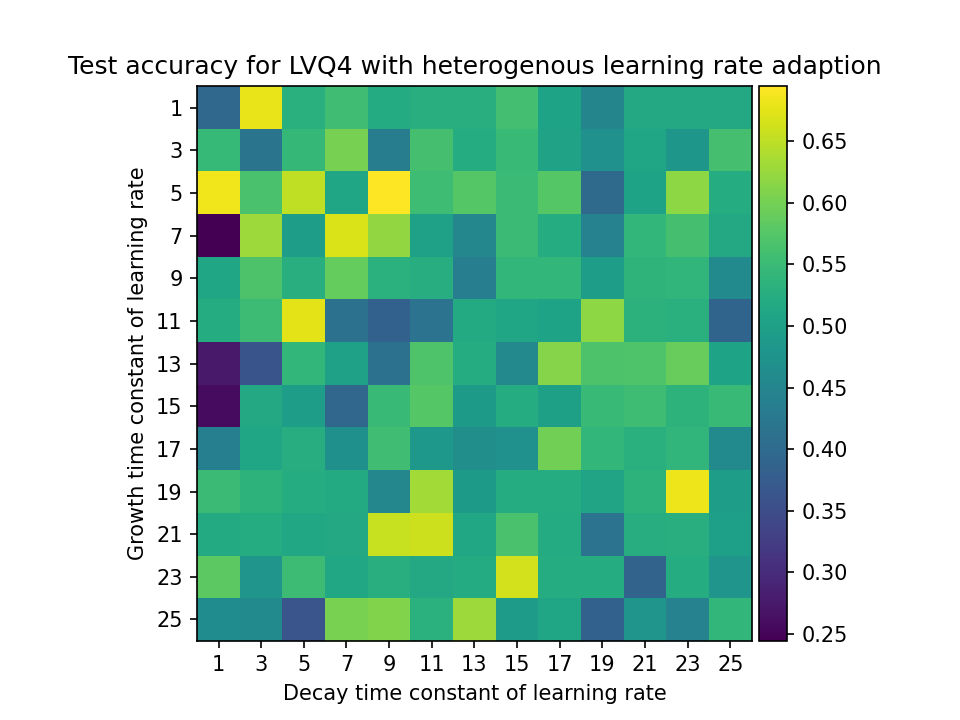

In [22]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig = plt.figure()
im=plt.imshow(accs)
ax = fig.axes[0]
plt.ylabel("Growth time constant of learning rate")
plt.xlabel("Decay time constant of learning rate")

plt.xticks(ticks=np.arange(len(tau_alpha_dc_list)),labels=tau_alpha_dc_list)
plt.yticks(np.arange(len(tau_alpha_gr_list)),tau_alpha_gr_list)
# ax.set_yticks(np.arange(len(alphas)))
# ax.set_yticklabels(alphas, fontsize=10)
# plt.xticks(sigmas)
# plt.yticks(n_neurons)
plt.title("Test accuracy for LVQ4 with heterogenous learning rate adaption")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)
plt.show()

## Comparison of Homogenous and Heterogenous Learning

In [132]:
importlib.reload(lvq.lvq3)
importlib.reload(lvq.lvq4)
from lvq.lvq3 import LVQ3
from lvq.lvq4 import LVQ4

X = flat_bounded
y = labels

# Share params between LVQ3 and LVQ4, both with dynamic prototypes
n_epochs = 1
n_class = 20
max_n_proto = 440
n_sample_per_class = int(X.shape[0]/n_class)
training_ratio = 0.40

# LVQ3 specific params
alpha = 0.1
alpha_decay = 'linear'

# LVQ4 specific params
alpha_start = alpha
d_alpha = 0.9

n_protos_list = range(200,max_n_proto+1,20)

# Take every nth sample as training for each class
n_tr_sample_per_class = int(n_sample_per_class*training_ratio)
mask = list(range(0,X.shape[0],int(n_sample_per_class/n_tr_sample_per_class)))
X_train = X[mask]
X_test = np.delete(X, mask, axis=0)
y_train = y[mask]
y_test = np.delete(y, mask, axis=0)

lvq3_test_accs = []
lvq4_test_accs = []
lvq3_train_accs = []
lvq4_train_accs = []

for ind, n_protos in enumerate(n_protos_list):
    print("n_protos: ", n_protos)
    # LVQ3
    mlvq3 = LVQ3(bmu_metric='dot_product', random_protos=True, alpha_decay=alpha_decay,
                 n_protos=n_protos, n_class=n_class)
    mlvq3.init_prototypes_from_data(X_train)
    mlvq3.train_prototypes(x_train=X_train, y_train=y_train, x_test=X_test , y_test=y_test,
                               alpha_start=alpha, n_epochs=n_epochs, test_each_epoch=False, shuffle=False)
    
    lvq3_test_accs.append(mlvq3.predict(X_test, y_test))
    lvq3_train_accs.append(1-mlvq3.train_errors[-1])
    
    
    # LVQ4
    mlvq4 = LVQ4(bmu_metric='dot_product', random_protos=True, alpha_decay=alpha_decay,
             n_protos=n_protos, 
             n_class=n_class,
             alpha_start=alpha_start)
    mlvq4.init_prototypes_from_data(X_train)
    mlvq4.train_prototypes(x_train=X_train, y_train=y_train, x_test=X_test , y_test=y_test,
                           d_alpha=d_alpha, n_epochs=n_epochs, test_each_epoch=False, shuffle=False)
    
    lvq4_test_accs.append(mlvq4.predict(X_test, y_test))
    lvq4_train_accs.append(1-mlvq4.train_errors[-1])
    
    print("LVQ3 acc: ",lvq3_test_accs[-1])
    print("LVQ4 acc: ",lvq4_test_accs[-1])

n_protos:  200
Initial prototypes:
 [[  6.8   7.8   2.8 ... 103.7 102.3  71.6]
 [  0.8   3.3   5.9 ...  71.1  79.  125.1]
 [ 14.8   4.3  18.7 ...  99.3 106.5  82. ]
 ...
 [  4.   12.4   2.2 ...  39.2  75.8 105.4]
 [  8.3   5.4  10.5 ... 128.8  98.  114.1]
 [  3.8   8.   10.9 ...  34.8  73.8  78.1]]
>epoch=0, lrate=0.100, tr_err=0.100, test_err=0.251
Initial prototypes:
 [[ 17.7   2.9  10.4 ...  70.4  90.3  87.2]
 [  0.5   5.    1.7 ...  93.2  97.5  66.4]
 [  9.    2.4   4.6 ...  92.2  89.9 128.5]
 ...
 [  0.4   6.4   5.5 ... 102.3 105.7  58.6]
 [  1.2  12.9   8.3 ... 102.6 105.7  87. ]
 [  2.2   6.5   8.5 ...  26.7 116.4 110.7]]
>epoch=0, lrate=0.100, tr_err=0.104, test_err=0.299
LVQ3 acc:  0.7486111111111111
LVQ4 acc:  0.7013888888888888
n_protos:  220
Initial prototypes:
 [[ 24.6   5.2   0.1 ...  95.7 118.3  60. ]
 [  6.6   5.   11.9 ...  84.7 119.2 109.2]
 [  0.5  13.7   3.6 ... 113.5  83.5  93.3]
 ...
 [  1.2   3.7   9.5 ...  86.  116.   85.9]
 [  1.6  20.3  20.  ... 102.7  82.  11

Initial prototypes:
 [[ 18.7   3.1  27.3 ... 119.2  94.1 103.4]
 [  3.6   3.3  18.  ... 124.5 108.2  84.8]
 [  2.3   9.   15.6 ... 149.3  71.6 133.5]
 ...
 [ 26.5  10.5   1.2 ...  76.8  68.1 105.9]
 [ 11.3   2.1   6.3 ... 110.1  91.5 108.8]
 [  0.3  12.3   4.4 ...  57.8  99.9 122.6]]
>epoch=0, lrate=0.100, tr_err=0.104, test_err=0.318
Initial prototypes:
 [[ 16.   10.4  22.  ...  92.   64.1  96.6]
 [  0.1  10.    9.  ... 107.7 104.3 106.9]
 [  4.5   6.9  21.7 ... 108.5  95.  117.9]
 ...
 [ 26.8   2.2   2.6 ... 125.7  81.4  78. ]
 [ 15.9   1.4  15.3 ...  57.2  70.2  93.7]
 [  3.4   1.6  15.8 ...  63.1  83.6  88.9]]
>epoch=0, lrate=0.081, tr_err=0.093, test_err=0.275
LVQ3 acc:  0.6819444444444445
LVQ4 acc:  0.725
n_protos:  440
Initial prototypes:
 [[ 10.   12.9   5.6 ...  79.7  63.   74.1]
 [  2.    2.2  12.6 ...  88.4 109.3 103.2]
 [  5.6   4.7  23.2 ... 111.3  97.8  42.7]
 ...
 [  9.    1.8  12.1 ... 126.6  95.2  87.6]
 [ 36.2  10.2  32.8 ...  86.2  82.8  83.4]
 [  0.8  19.5   3.4 ...

In [ ]:
plt.figure(figsize=(9,9))
    
plt.plot(n_protos_list, lvq3_test_accs)
plt.plot(n_protos_list, lvq4_test_accs)
plt.plot(n_protos_list, lvq3_train_accs, '--')
plt.plot(n_protos_list, lvq4_train_accs, '--')



plt.ylim([0,1.05])
plt.yticks(np.arange(0,1.05,0.05))
plt.grid()
plt.xlabel("# of the dynamic prototypes")
plt.ylabel("Accuracy")
plt.legend(labels=["LVQ3 Test Accuracy",
                   "LVQ4 Test Accuracy",
                   "LVQ3 Training Accuracy",
                   "LVQ4 Training Accuracy"])
plt.title("LVQ3 vs LVQ4: Homogenous versus Heterogenous learning Final Training and Test Error \n with different number of the dynamic prototypes with 40% of rotations")

plt.show()

In [134]:
# Share params between LVQ3 and LVQ4, both with dynamic prototypes
n_epochs = 40
n_class = 20
n_protos = 200
n_sample_per_class = int(X.shape[0]/n_class)
training_ratios = np.arange(0.02,0.54,0.04)

# LVQ3 specific params
alpha = 0.02
alpha_decay = 'linear'

# LVQ4 specific params
alpha_start = 0.06
d_alpha = 0.8

lvq3_test_accs = []
lvq4_test_accs = []
lvq3_train_accs = []
lvq4_train_accs = []


for ind, training_ratio in enumerate(training_ratios):
    # Take every nth sample as training for each class
    n_tr_sample_per_class = int(n_sample_per_class*training_ratio)
    mask = list(range(0,X.shape[0],int(n_sample_per_class/n_tr_sample_per_class)))
    X_train = X[mask]
    X_test = np.delete(X, mask, axis=0)
    y_train = y[mask]
    y_test = np.delete(y, mask, axis=0)
    
    print("n_protos: ", n_protos)
    # LVQ3
    mlvq3 = LVQ3(bmu_metric='dot_product', random_protos=True, alpha_decay=alpha_decay,
                 n_protos=n_protos, n_class=n_class)
    
    mlvq3.train_prototypes(x_train=X_train, y_train=y_train, x_test=X_test , y_test=y_test,
                               alpha_start=alpha, n_epochs=n_epochs, test_each_epoch=False, shuffle=False)
    
    lvq3_test_accs.append(mlvq3.predict(X_test, y_test))
    lvq3_train_accs.append(1-mlvq3.train_errors[-1])
    
    # LVQ4
    mlvq4 = LVQ4(bmu_metric='dot_product', random_protos=True, alpha_decay=alpha_decay,
                 n_protos=n_protos, 
                 n_class=n_class,
                 alpha_start=alpha_start)
    mlvq4.train_prototypes(x_train=X_train, y_train=y_train, x_test=X_test , y_test=y_test,
                           d_alpha=d_alpha, n_epochs=n_epochs, test_each_epoch=False, shuffle=False)

    lvq4_test_accs.append(mlvq4.predict(X_test, y_test))
    lvq4_train_accs.append(1-mlvq4.train_errors[-1])
    
    print("LVQ3 acc: ",lvq3_test_accs[-1])
    print("LVQ4 acc: ",lvq4_test_accs[-1])

n_protos:  200
Initial prototypes:
 [[ 1.4 19.4 20.1 ... 28.8 27.9 17.2]
 [12.1 27.2 21.1 ... 31.2 38.6 15.5]
 [11.3 20.4  2.9 ... 28.7  6.3 33.3]
 ...
 [23.3 30.8 28.1 ...  0.5 33.5 32.4]
 [21.1 10.1 41.6 ...  7.6 16.5 20. ]
 [35.8 23.   7.3 ...  5.3  6.7 13.5]]
>epoch=0, lrate=0.020, tr_err=0.400, test_err=0.000
>epoch=1, lrate=0.019, tr_err=0.300, test_err=0.000
>epoch=2, lrate=0.019, tr_err=0.250, test_err=0.000
>epoch=3, lrate=0.018, tr_err=0.250, test_err=0.000
>epoch=4, lrate=0.018, tr_err=0.250, test_err=0.000
>epoch=5, lrate=0.017, tr_err=0.250, test_err=0.000
>epoch=6, lrate=0.017, tr_err=0.250, test_err=0.000
>epoch=7, lrate=0.016, tr_err=0.250, test_err=0.000
>epoch=8, lrate=0.016, tr_err=0.250, test_err=0.000
>epoch=9, lrate=0.015, tr_err=0.250, test_err=0.000
>epoch=10, lrate=0.015, tr_err=0.250, test_err=0.000
>epoch=11, lrate=0.014, tr_err=0.250, test_err=0.000
>epoch=12, lrate=0.014, tr_err=0.250, test_err=0.000
>epoch=13, lrate=0.013, tr_err=0.250, test_err=0.000
>epo

>epoch=15, lrate=0.000, tr_err=0.200, test_err=0.000
>epoch=16, lrate=0.060, tr_err=0.175, test_err=0.000
>epoch=17, lrate=0.060, tr_err=0.175, test_err=0.000
>epoch=18, lrate=0.060, tr_err=0.188, test_err=0.000
>epoch=19, lrate=0.060, tr_err=0.175, test_err=0.000
>epoch=20, lrate=0.060, tr_err=0.175, test_err=0.000
>epoch=21, lrate=0.060, tr_err=0.175, test_err=0.000
>epoch=22, lrate=0.060, tr_err=0.188, test_err=0.000
>epoch=23, lrate=0.060, tr_err=0.188, test_err=0.000
>epoch=24, lrate=0.060, tr_err=0.175, test_err=0.000
>epoch=25, lrate=0.060, tr_err=0.175, test_err=0.000
>epoch=26, lrate=0.060, tr_err=0.175, test_err=0.000
>epoch=27, lrate=0.060, tr_err=0.188, test_err=0.000
>epoch=28, lrate=0.060, tr_err=0.175, test_err=0.000
>epoch=29, lrate=0.060, tr_err=0.175, test_err=0.000
>epoch=30, lrate=0.060, tr_err=0.175, test_err=0.000
>epoch=31, lrate=0.038, tr_err=0.175, test_err=0.000
>epoch=32, lrate=0.060, tr_err=0.188, test_err=0.000
>epoch=33, lrate=0.060, tr_err=0.175, test_err

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


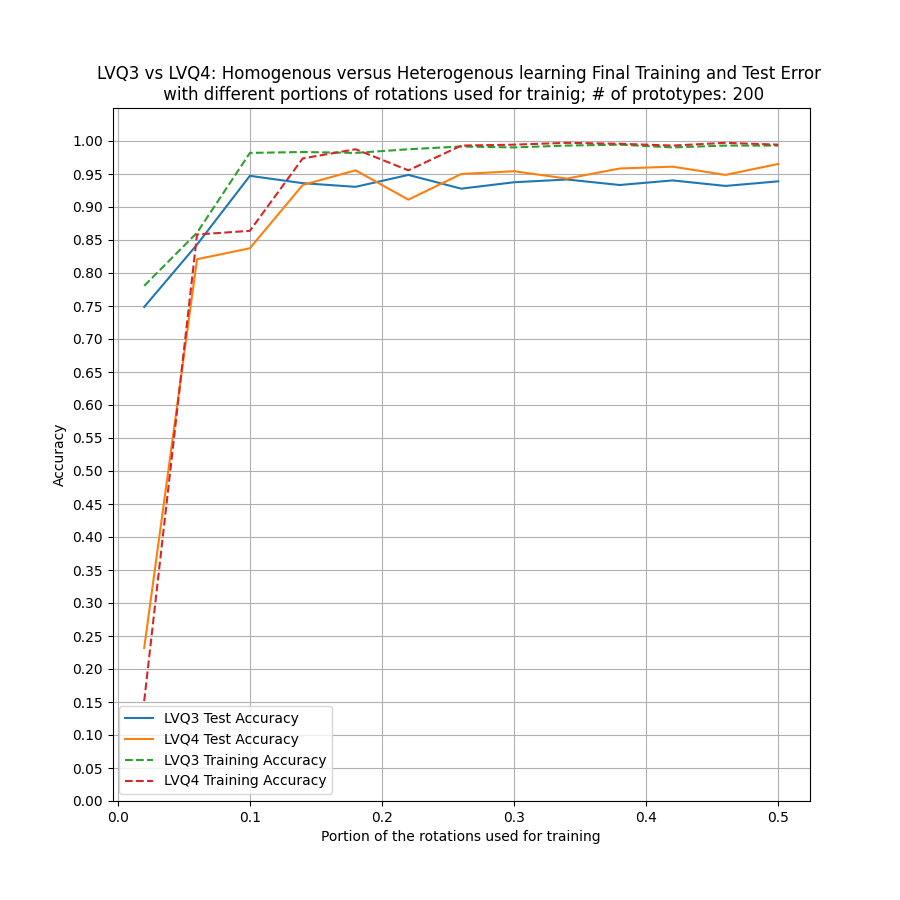

In [61]:
plt.figure(figsize=(9,9))
    
plt.plot(training_ratios, lvq3_test_accs)
plt.plot(training_ratios, lvq4_test_accs)
plt.plot(training_ratios, lvq3_train_accs, '--')
plt.plot(training_ratios, lvq4_train_accs, '--')



plt.ylim([0,1.05])
plt.yticks(np.arange(0,1.05,0.05))
plt.grid()
plt.xlabel("Portion of the rotations used for training")
plt.ylabel("Accuracy")
plt.legend(labels=["LVQ3 Test Accuracy",
                   "LVQ4 Test Accuracy",
                   "LVQ3 Training Accuracy",
                   "LVQ4 Training Accuracy"])
plt.title("LVQ3 vs LVQ4: Homogenous versus Heterogenous learning Final Training and Test Error \n with different portions of rotations used for trainig; # of prototypes: 200")

plt.show()